# seqFISH dataset

This is an example to show you how to run analysis without cell type information

In [1]:
import pandas as pd
import anndata as ad
import scanpy as sc
sc.settings.verbosity = 3

import spatialtis as st
import spatialtis.plotting as sp
from spatialtis import CONFIG

data = ad.read_h5ad("../data/seqFISH-OB.h5ad")
data.obs['cell_type'] = 'unknown'
data

AnnData object with n_obs × n_vars = 2050 × 10000
    obs: 'FOV', 'centroid', 'cell_type'
    var: 'markers'

In [2]:
CONFIG.EXP_OBS = ["FOV"] 
CONFIG.CELL_TYPE_KEY = "cell_type"
CONFIG.MARKER_KEY = "markers"
CONFIG.CENTROID_KEY = "centroid"

Here, we used `scanpy` to filter out some low expressed cells and genes, and then we select some highly-variable genes out.

In [3]:
sc.pp.filter_cells(data, min_genes=200)
sc.pp.filter_genes(data, min_cells=100)

sc.pp.normalize_total(data, target_sum=100)
sc.pp.log1p(data)
sc.pp.highly_variable_genes(data, min_mean=0.0125, min_disp=0.5)

filtered out 85 cells that have less than 200 genes expressed
filtered out 4264 genes that are detected in less than 100 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [4]:
selected_markers = []
for m, hv in zip(data.var.markers, data.var.highly_variable):
    if hv:
        selected_markers.append(m)

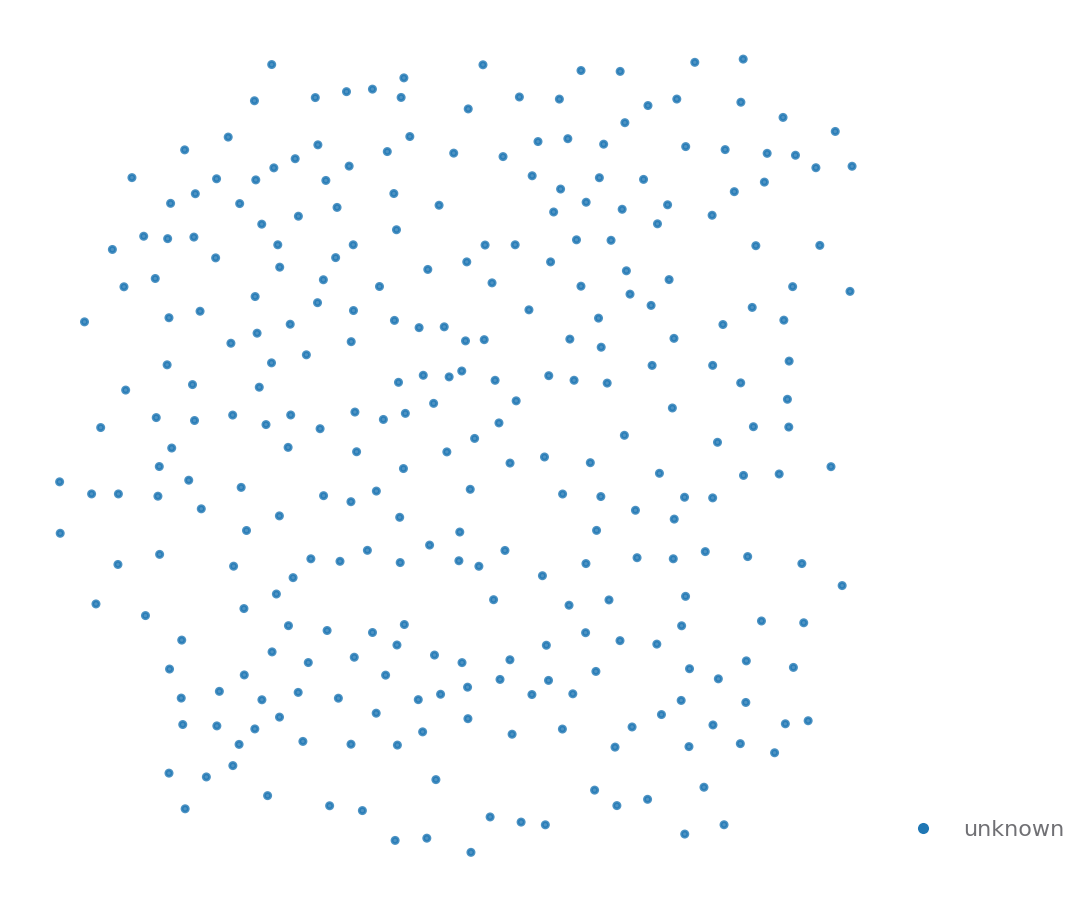

In [5]:
sp.cell_map(data, {"FOV": 2}, cell_type_key="cell_type")

In [6]:
st.find_neighbors(data, expand=120)

Find neighbors ██████████ 100% 00:00|00:00


In [7]:
data.obs.cell_neighbors_count.mean()

5.993384223918575

In [8]:
st.spatial_co_expression(data, selected_markers=selected_markers)

co-expression ██████████ 100% 00:00|00:07


In [9]:
st.get_result(data, 'co_expression')

,marker1,marker2,corr,pvalue


(pid=6515) Error in atexit._run_exitfuncs:
(pid=6515) Traceback (most recent call last):
(pid=6515)   File "/Users/milk/anaconda3/envs/spatialtis/lib/python3.8/site-packages/IPython/core/history.py", line 780, in writeout_cache
(pid=6515)     self._writeout_input_cache(conn)
(pid=6515)   File "/Users/milk/anaconda3/envs/spatialtis/lib/python3.8/site-packages/IPython/core/history.py", line 763, in _writeout_input_cache
(pid=6515)     conn.execute("INSERT INTO history VALUES (?, ?, ?, ?)",
(pid=6515) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 123145405095936 and this is thread id 4672364032.


In [10]:
st.NMDMarkers(data, exp_std_cutoff=0.1, selected_markers=selected_markers)

NMD Markers ██████████ 100% 00:00|01:28


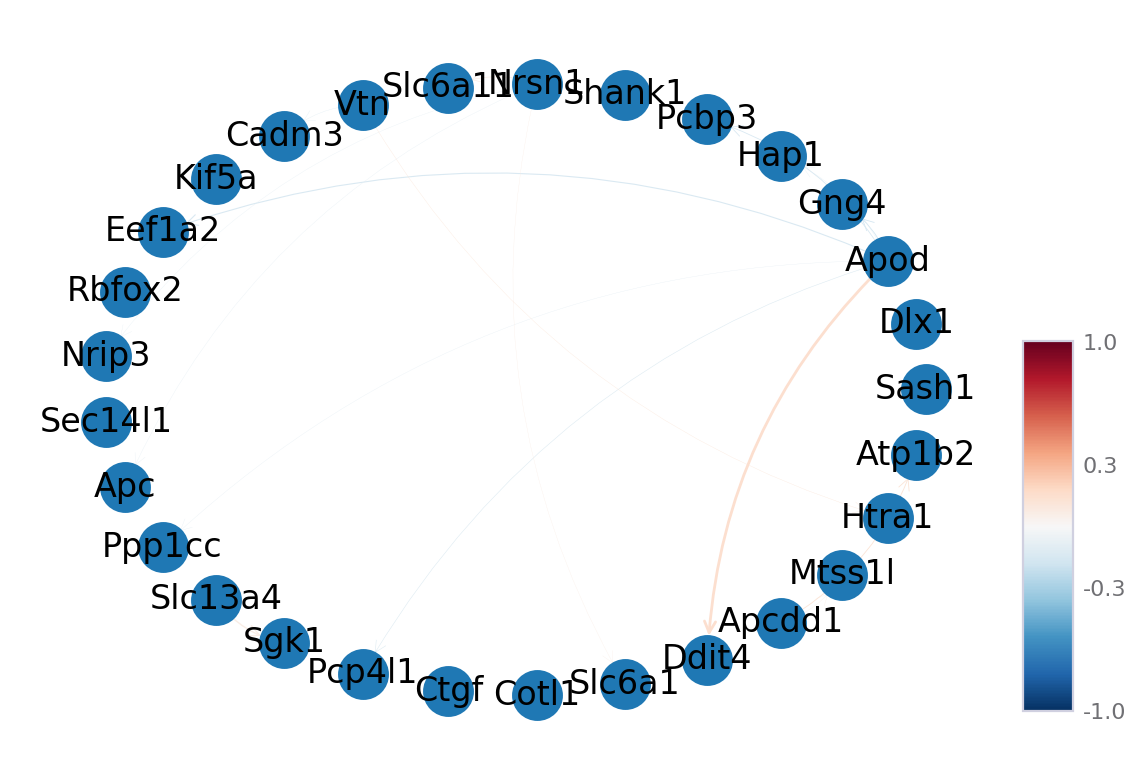

In [11]:
sp.NMDMarkers(data)

In [12]:
def co_exp(data, gene1, gene2):
    mdata = data.var.reset_index(drop=True)
    gene1_ix = mdata[mdata['markers'] == gene1].index.values[0]
    gene2_ix = mdata[mdata['markers'] == gene2].index.values[0]
    gene1_X = [f'{gene1}+' if i else f'{gene1}-' for i in (data.X[:, gene1_ix] > data.X[: gene1_ix].mean())]
    gene2_X = [f'{gene2}+' if i else f'{gene2}-' for i in (data.X[:, gene2_ix] > data.X[: gene2_ix].mean())]
    data.obs[f'{gene1}-{gene2}'] = (pd.Series(gene1_X) + pd.Series(gene2_X)).tolist()

In [13]:
co_exp(data, 'Apod', 'Vtn')

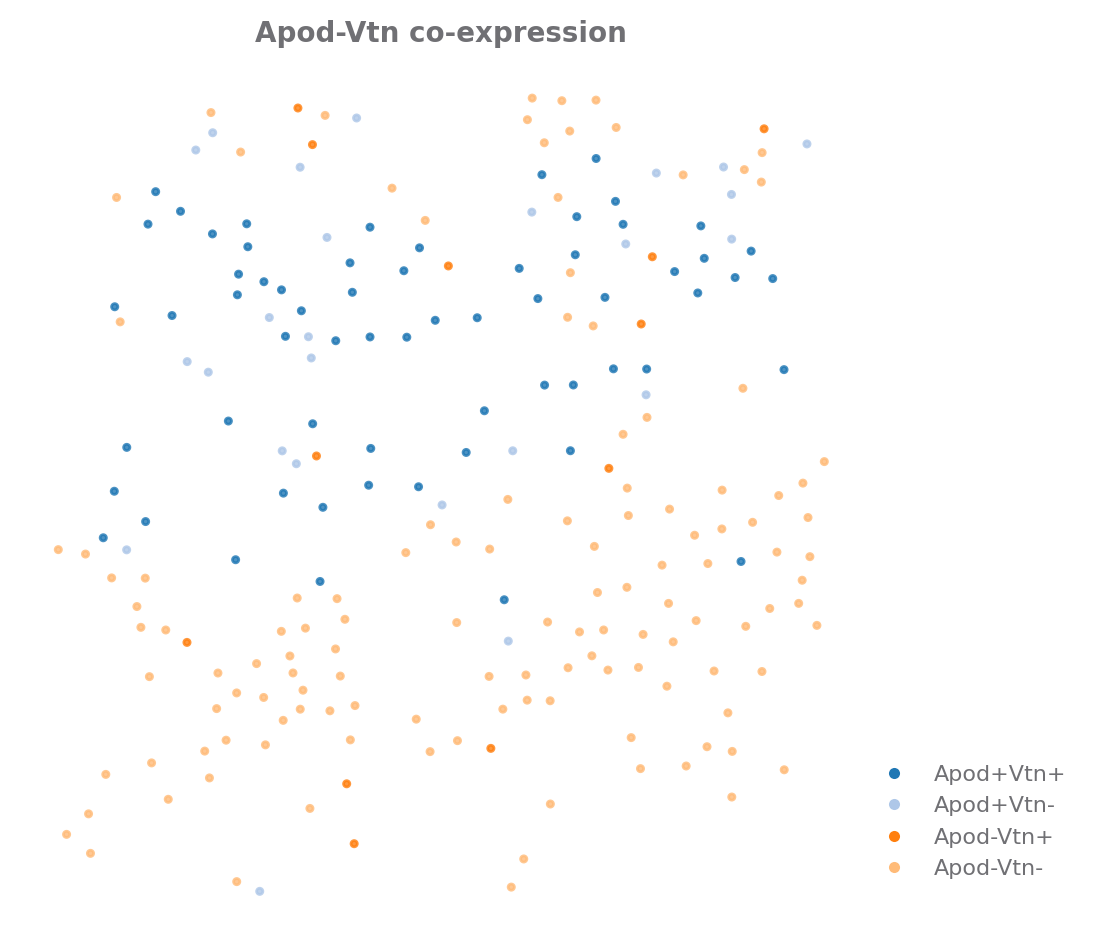

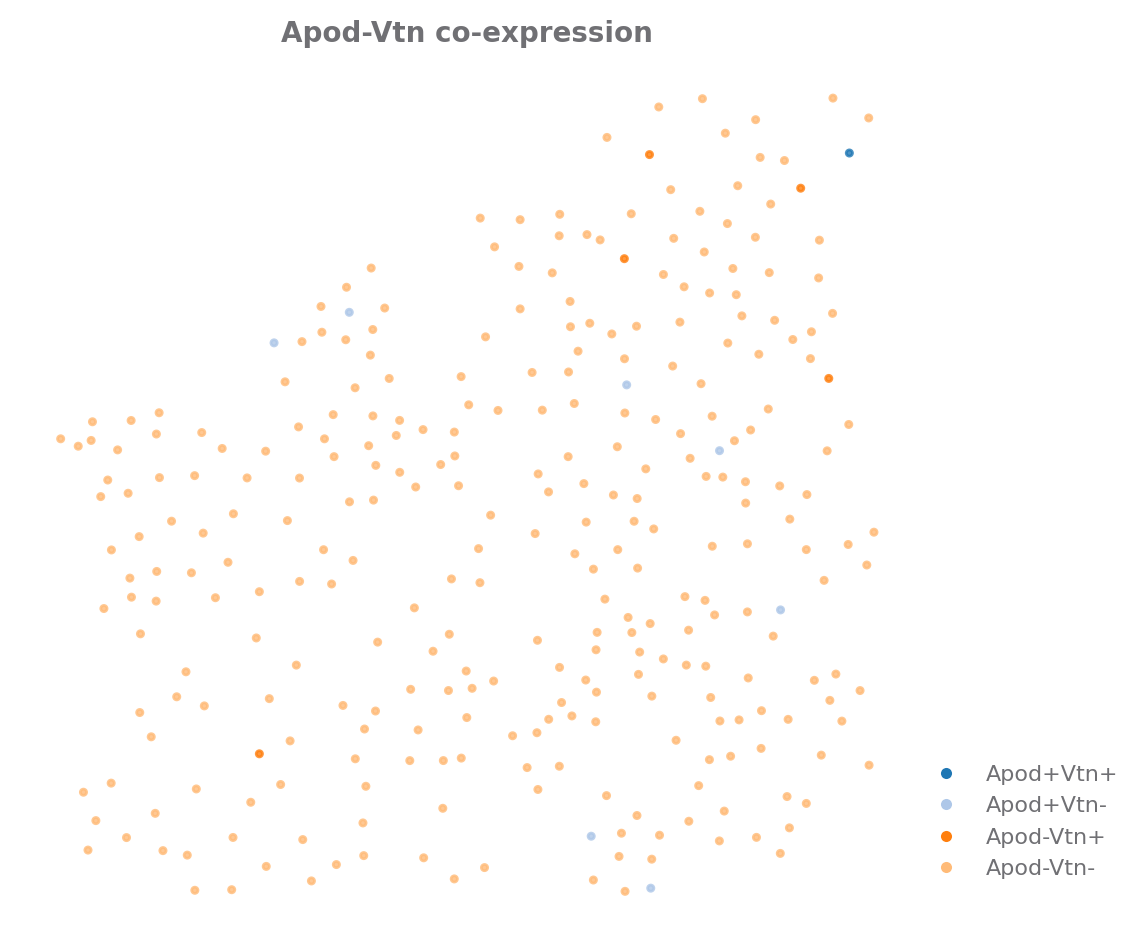

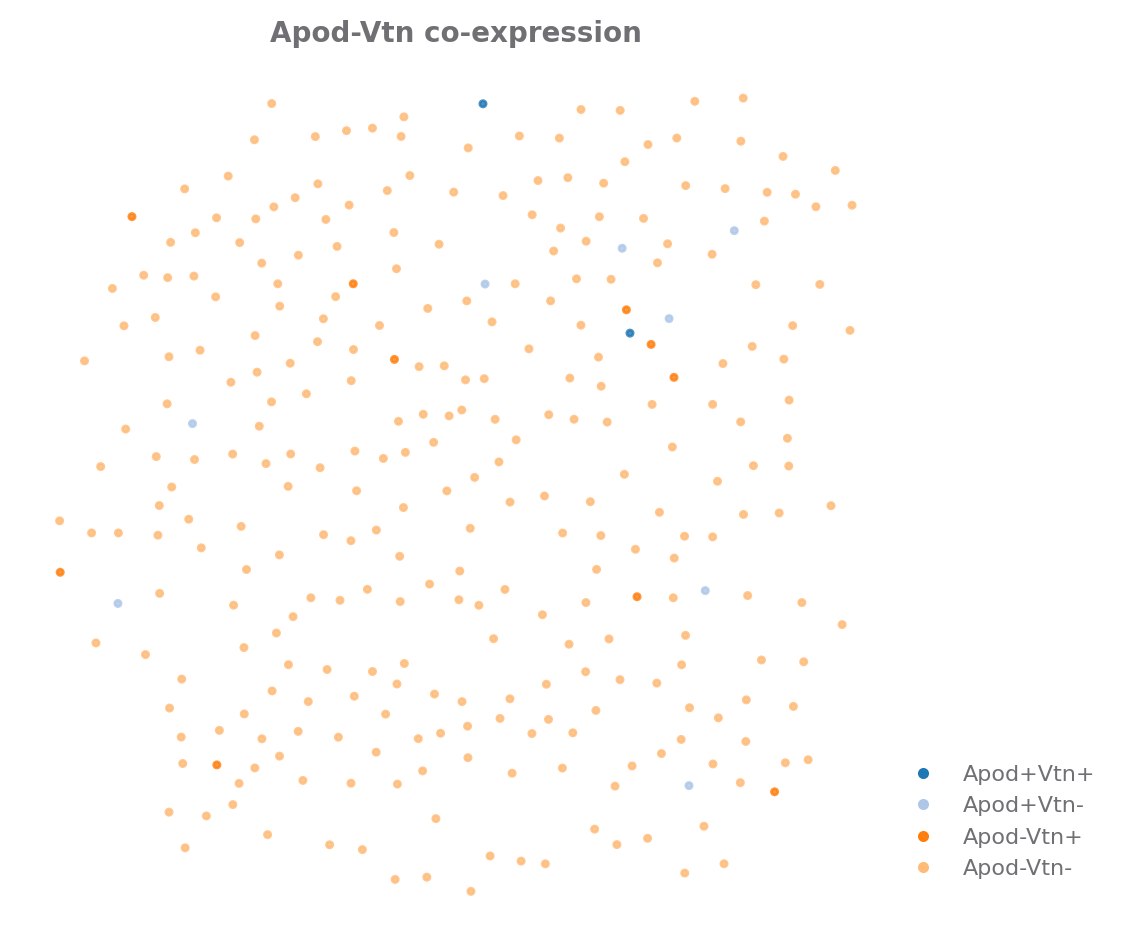

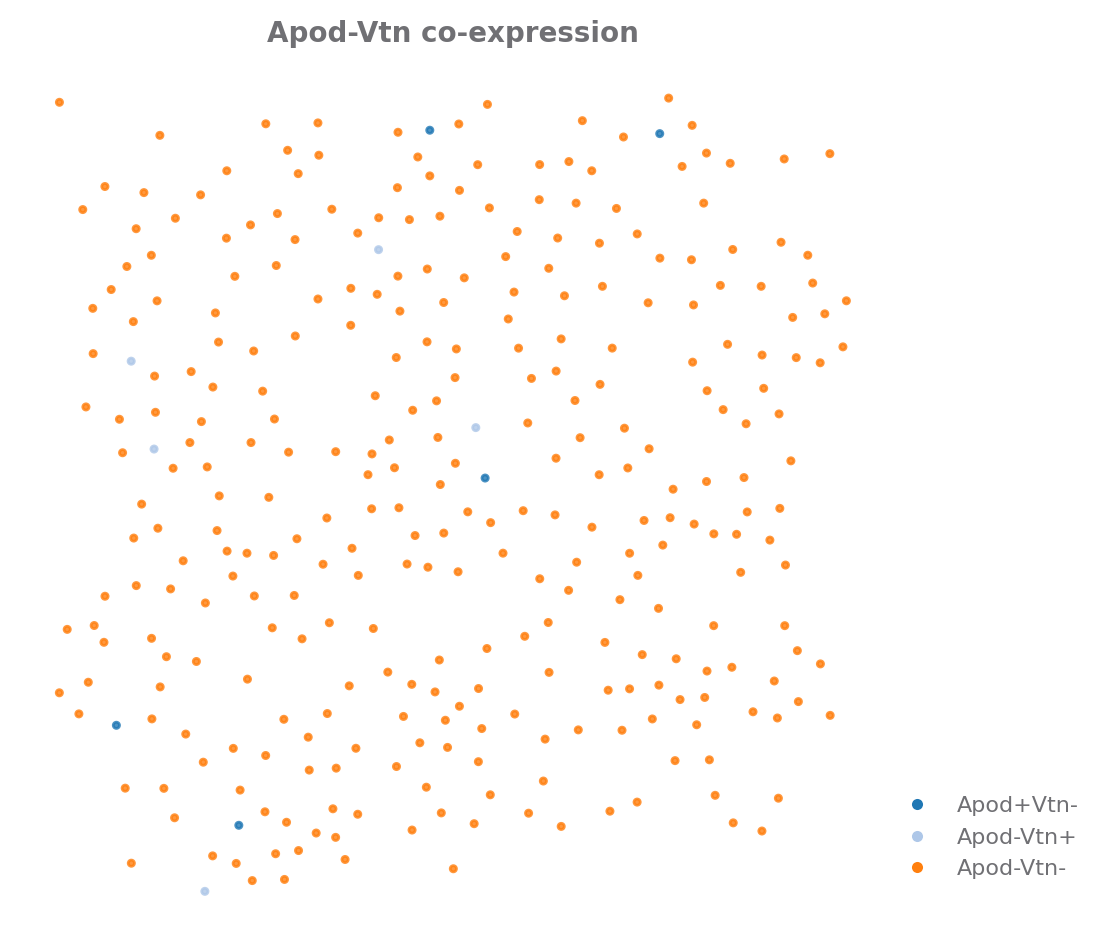

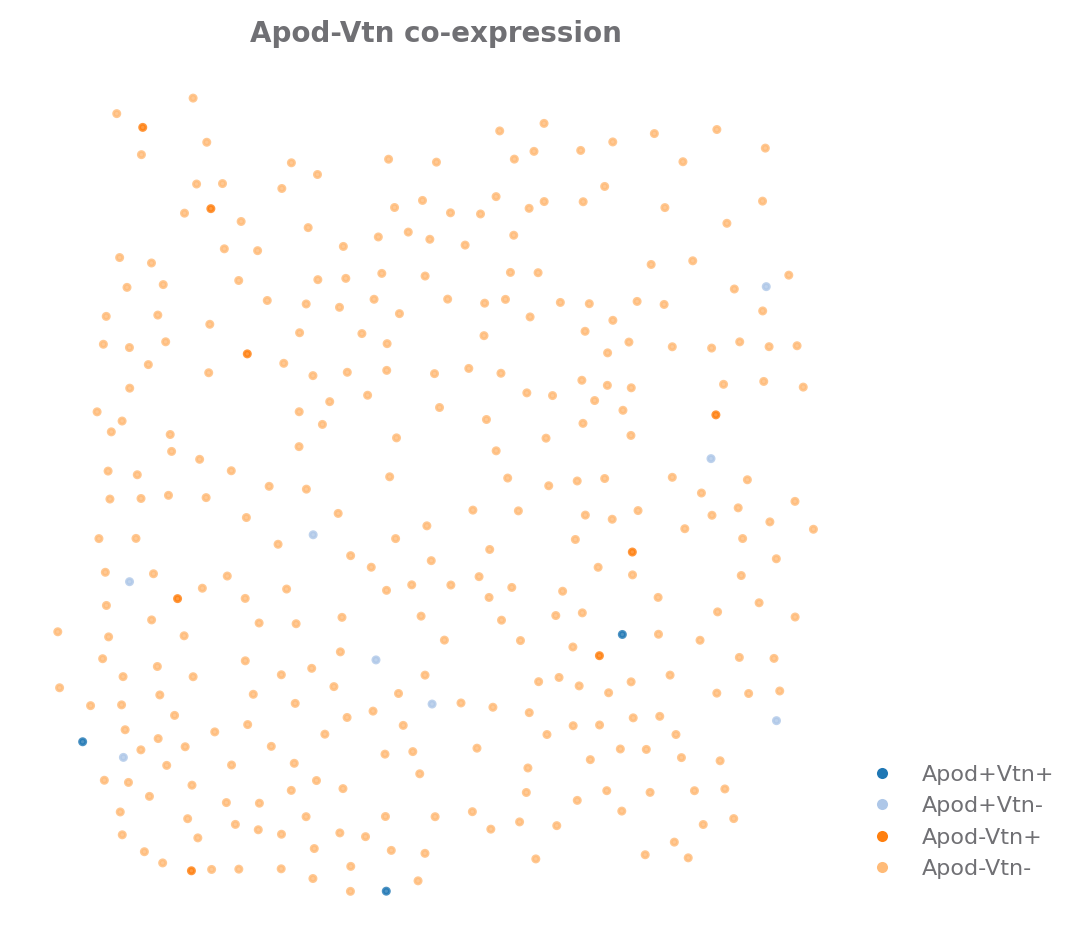

In [14]:
for i in range(5):
    sp.cell_map(data, {"FOV": i}, cell_type_key='Apod-Vtn', title="Apod-Vtn co-expression", size=(3, 3))
# sp.cell_map(data, {"FOV": 1}, cell_type_key='Apod-Vtn', title="Apod-Vtn co-expression")
# sp.cell_map(data, {"FOV": 2}, cell_type_key='Apod-Vtn', title="Apod-Vtn co-expression")
#sp.expression_map(data, {"FOV": 0}, "Apod", title="Apod")
#sp.expression_map(data, {"FOV": 0}, "Vtn", title="Vtn")

In [15]:
co_exp(data, 'Hap1', 'Gng4')

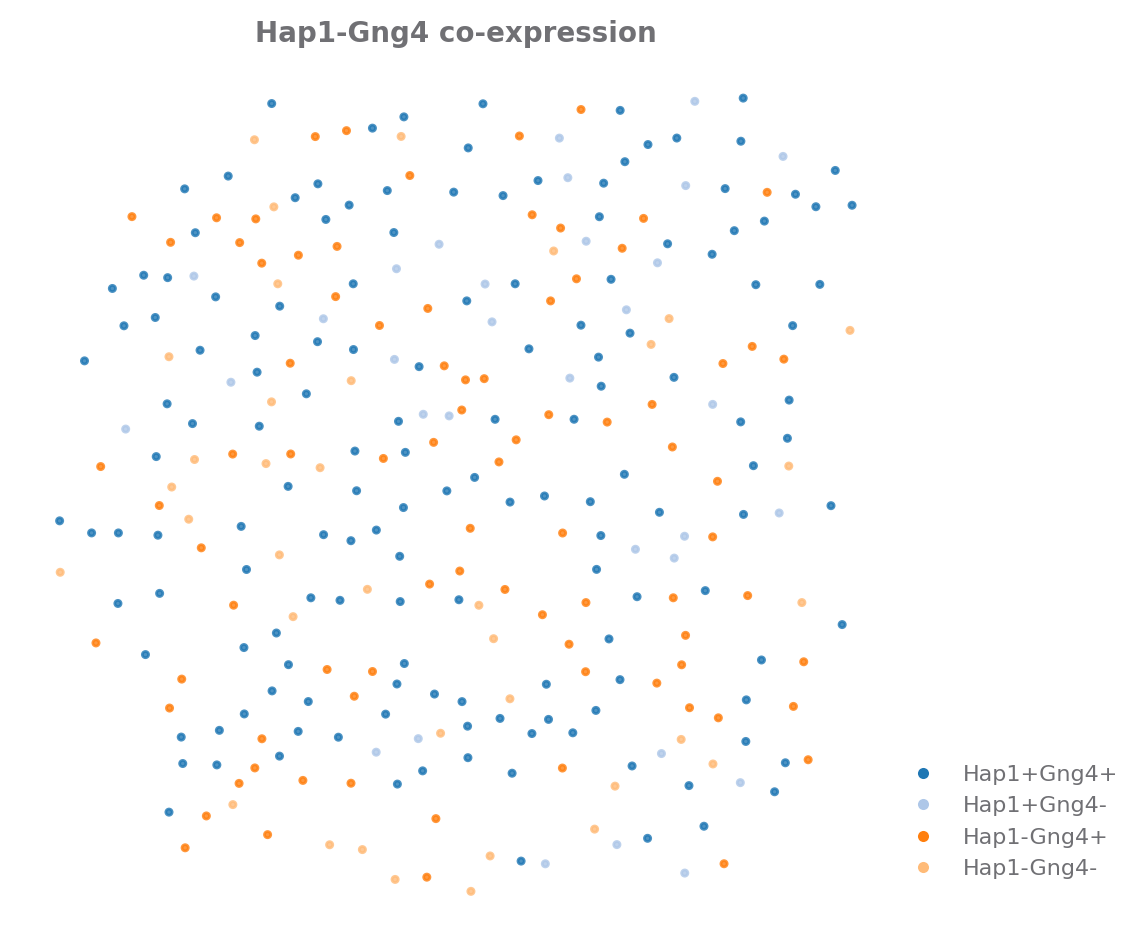

In [16]:
sp.cell_map(data, {"FOV": 2}, cell_type_key='Hap1-Gng4', title="Hap1-Gng4 co-expression")
#sp.cell_map(data, {"FOV": 1}, cell_type_key='Hap1-Gng4', title="Apod-Vtn co-expression")
#sp.cell_map(data, {"FOV": 2}, cell_type_key='Hap1-Gng4', title="Apod-Vtn co-expression")
#sp.expression_map(data, {"FOV": 0}, "Apod", title="Apod")
#sp.expression_map(data, {"FOV": 0}, "Vtn", title="Vtn")

To run some GO analysis

In [17]:
import gseapy
gl = pd.unique(st.get_result(data, 'nmd_markers')[['marker', 'neighbor_marker']].to_numpy().flatten())
gseapy.enrichr(gene_list=gl.tolist(), organism="mouse", 
               description='pathway', gene_sets='GO_Biological_Process_2015', outdir='go', format="png")

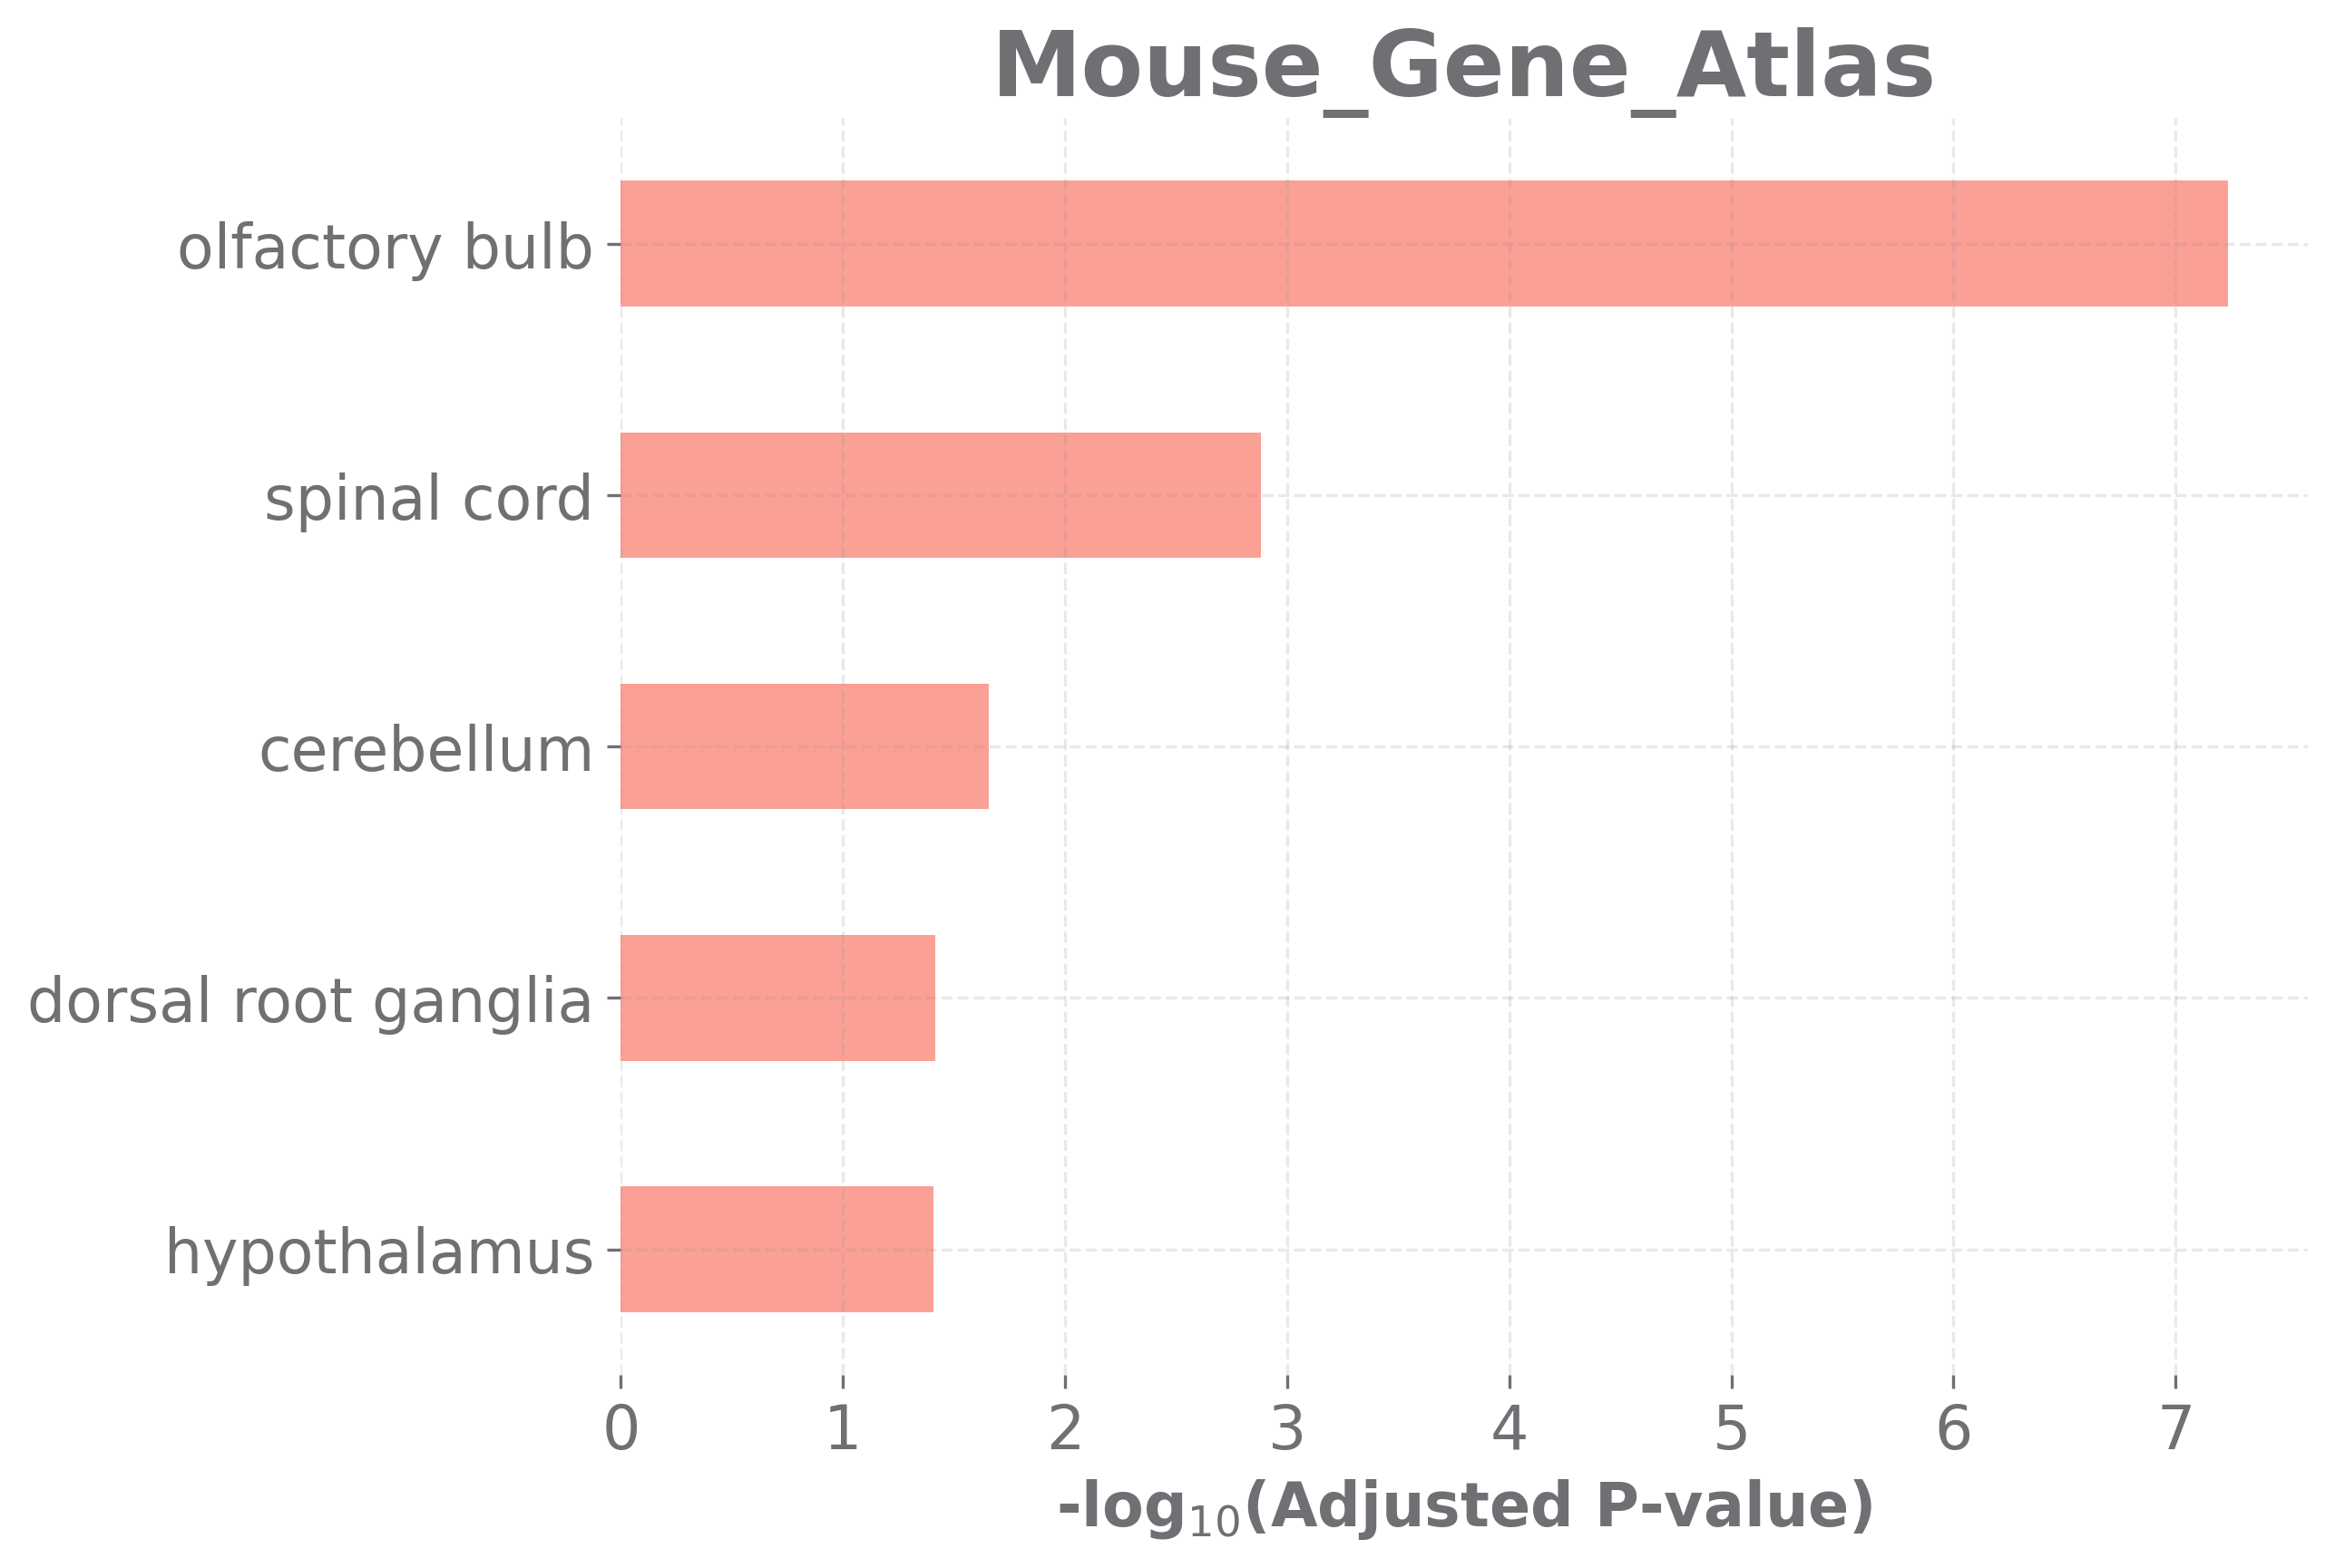

In [18]:
from IPython.display import Image
Image(filename='go/Mouse_Gene_Atlas.mouse.enrichr.reports.png', width=400)

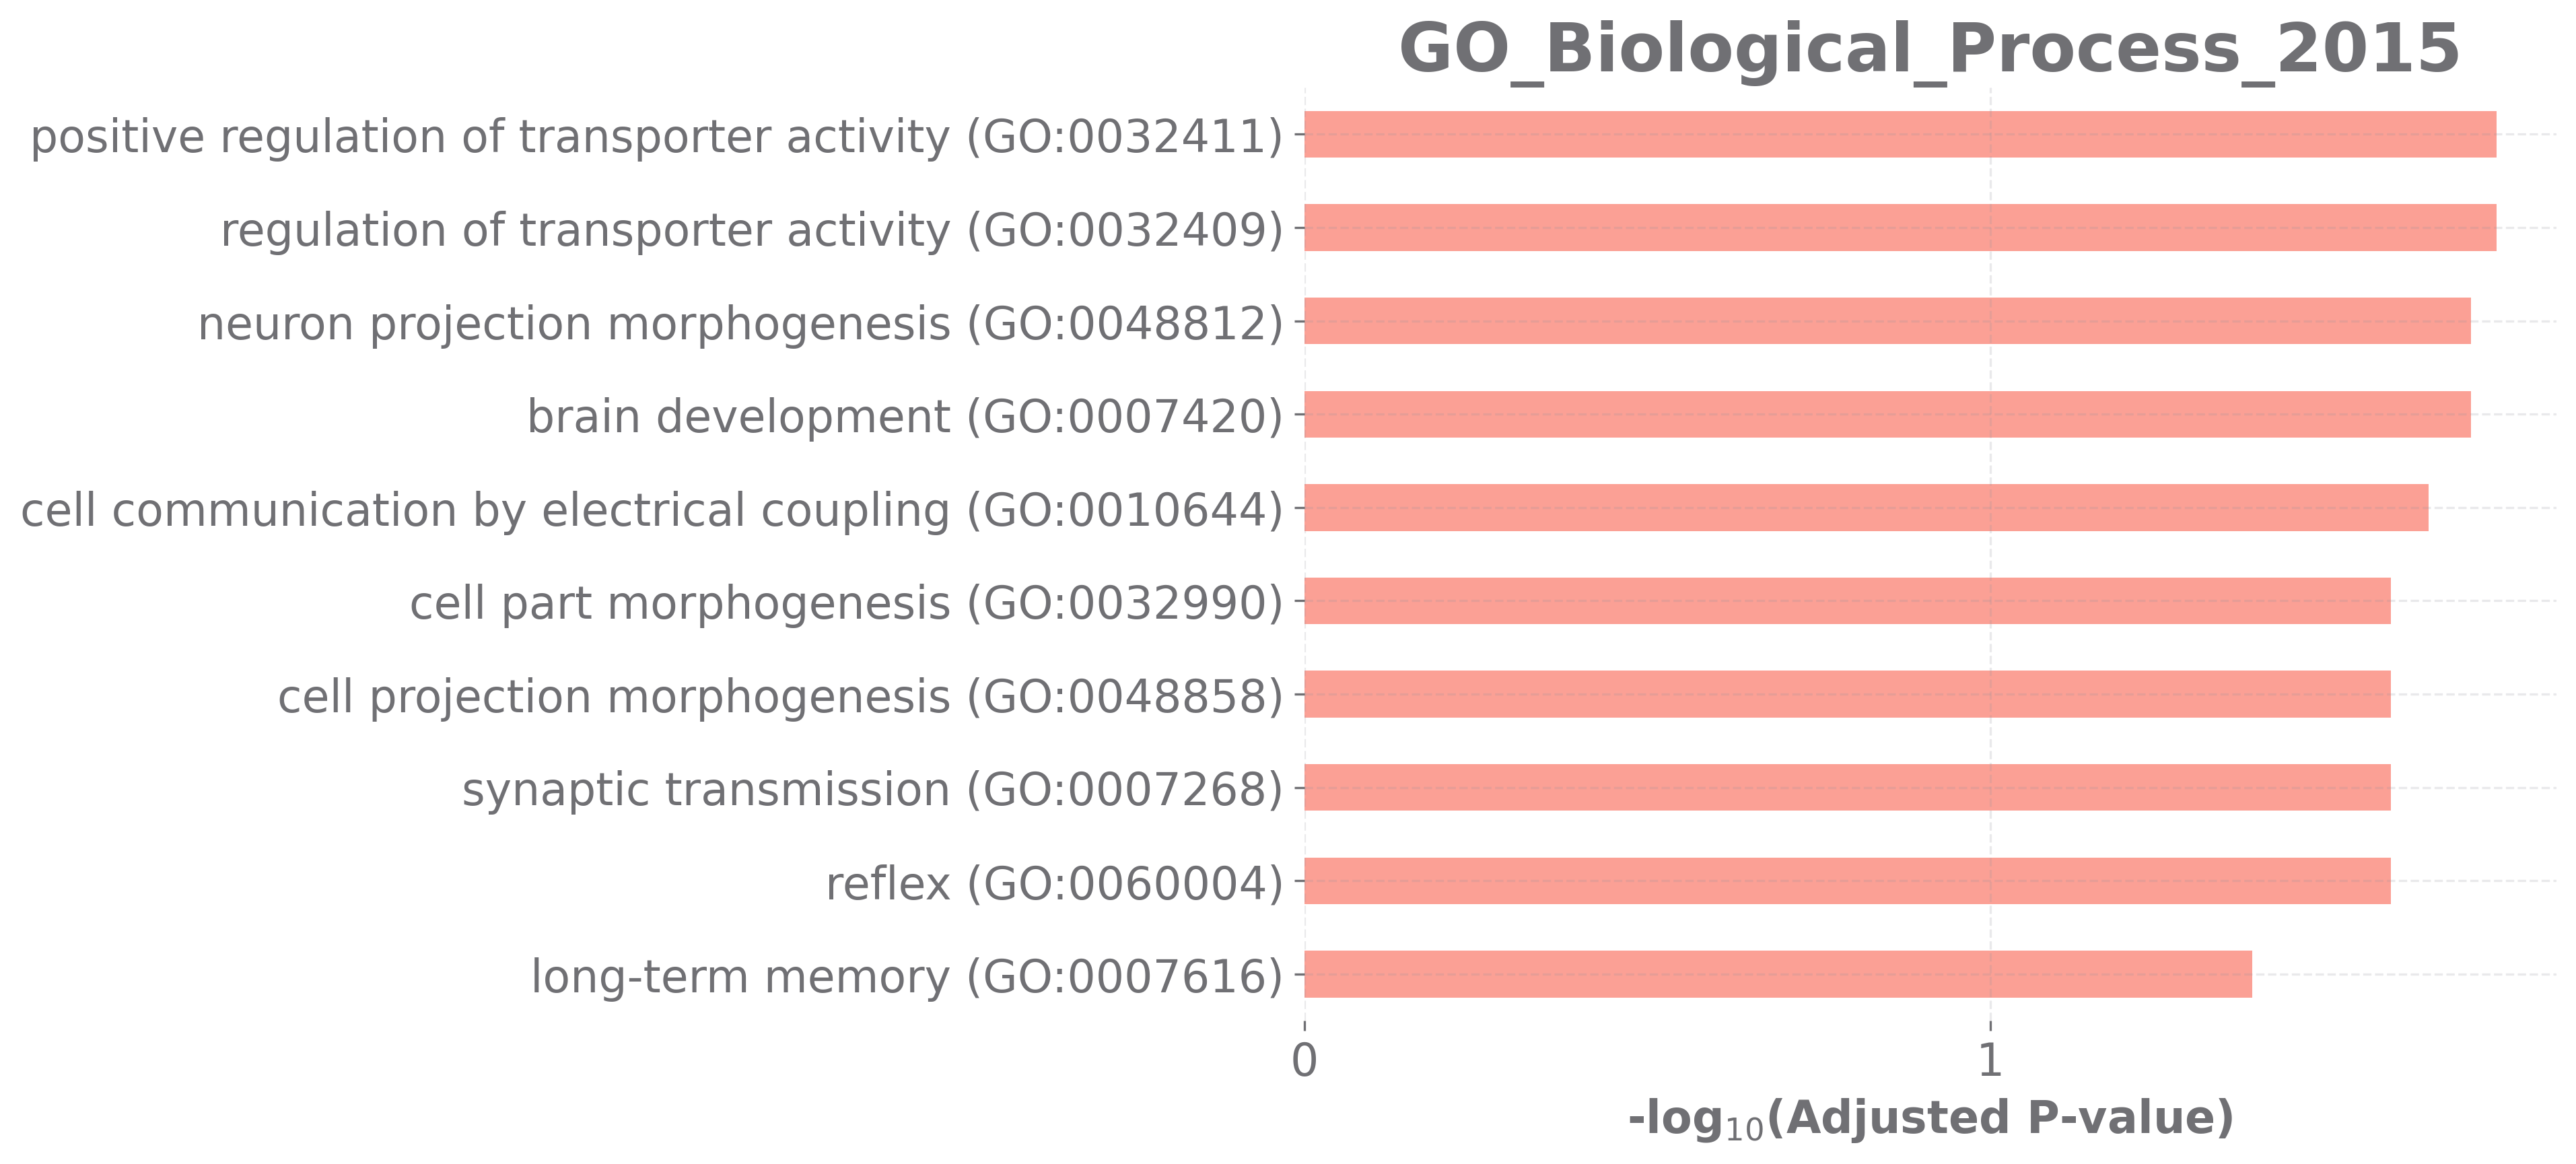

In [19]:
Image(filename='go/GO_Biological_Process_2015.mouse.enrichr.reports.png', width=700)